In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import pandas as pd
import heapq


In [ ]:
class Node:
    def __init__(self, x, y, number):
        self.x = x # x and y coordinates on the map for the node
        self.y = y
        self.number = number # just to give it a name
        self.neighbors = [] # list of conections to other nodes
        self.g = 0 # cost of getting to the node from the start 
        self.h = 0 # heuristic value for the node
        self.f = 0 # addition of the g and h values
        self.parent = None # where does this node comes from 

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

    def get_coordinates(self):
        return self.x, self.y
    
    def __lt__(self, other):
        return self.f < other.f
    
    def __repr__(self):
        return f"Node {self.number} at ({self.x}, {self.y})"
    
    def calculate_h(self, goal, heuristic_type = "eucliean"):
        if heuristic_type == "manhattan":
            self.h = abs(self.x - goal.x) + abs(self.y - goal.y)
        elif heuristic_type == "euclidean":
            self.h = np.sqrt((self.x - goal.x)**2 + (self.y - goal.y)**2)
        pass




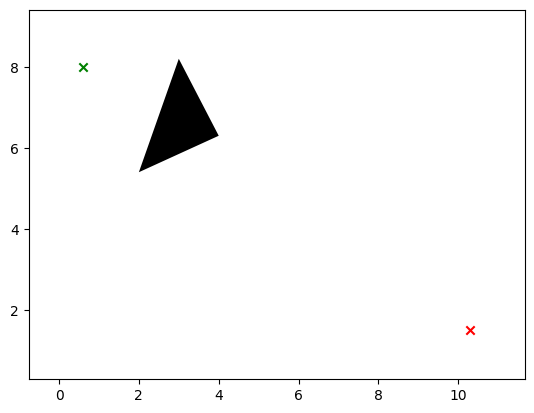

[Node 0 at (0.6, 8.0), Node 1 at (3.0, 8.2), Node 2 at (4.0, 6.3), Node 3 at (2.0, 5.4), Node 4 at (10.3, 1.5)]


In [20]:
env = "0"
vertices = pd.read_csv("env_"+env+".csv")
first_column_data = vertices[vertices.columns[0]]

a = []
polygons = []
nodes = []
pol_number = 0
node_number = 0

xs, ys = vertices[vertices.columns[1]][0], vertices[vertices.columns[2]][0] 

for i in range (len(first_column_data)):
    x,y = vertices[vertices.columns[1]][i], vertices[vertices.columns[2]][i] 
    nodes.append(Node(x,y,node_number))
    node_number += 1
    if pol_number != vertices[vertices.columns[0]][i]:
        polygons.append(a)
        pol_number = vertices[vertices.columns[0]][i]
        a = []
    a.append([x,y])

goal = x,y

fig,ax = plt.subplots()

for i in range(1, len(polygons)):
    ax.add_patch(matplotlib.patches.Polygon(polygons[i], facecolor = 'k'))

min_x = min(vertices[vertices.columns[1]])
max_x = max(vertices[vertices.columns[1]])
min_y = min(vertices[vertices.columns[2]])
max_y = max(vertices[vertices.columns[2]])

mean_x = (min_x + max_x)/8
mean_y = (min_y + max_y)/8

ax.scatter(xs,ys, marker = "x", c="g")
ax.scatter(goal[0],goal[1], marker = "x", c="r")
ax.set_xlim([min_x - mean_x, max_x + mean_x])
ax.set_ylim([min_y - mean_y, max_y + mean_y])
plt.show()

print (nodes)


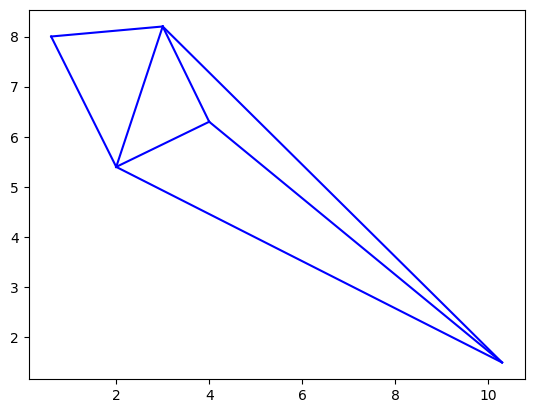

In [21]:
lines = pd.read_csv("visibility_graph_env_"+env+".csv")
connections = []

first_column_data = lines[lines.columns[0]]

for i in range (len(first_column_data)):
    x1,y1 = lines[lines.columns[0]][i], lines[lines.columns[1]][i]
    nodes[x1].add_neighbor(nodes[y1])
    nodes[y1].add_neighbor(nodes[x1])
    connectionsx = [vertices[vertices.columns[1]][x1], vertices[vertices.columns[1]][y1]]
    connectionsy = [vertices[vertices.columns[2]][x1], vertices[vertices.columns[2]][y1]]
    plt.plot(connectionsx, connectionsy, c = 'b')
plt.show()

In [22]:

for i in nodes:
    i.calculate_h(goal)
print (nodes)

[Node 0 at (0.6, 8.0), Node 1 at (3.0, 8.2), Node 2 at (4.0, 6.3), Node 3 at (2.0, 5.4), Node 4 at (10.3, 1.5)]


In [23]:
def a_star_conti(nodes):

    # A* algorithm
    # nodes is a list of Node objects
    # each Node object has a list of neighbors
    # each neighbor is a Node object
    # each Node object has a g, h, and f value
    # g is the cost to get to the node
    # h is the heuristic value
    # f is the sum of g and h
    # the goal is to find the path from the start node to the goal node
    # the path is a list of Node objects
    # the path should be the shortest path from the start node to the goal node
    # the path should be a list of Node objects
    # if there is no path, return None

    open_list = []
    closed_list = []
    start = nodes[0]
    start.f = start.h
    goal = nodes[-1]
    open_list.append(start)
    while open_list:

        current_node = open_list[0]
        for node in open_list:
            if node.f < current_node.f:
                current_node = node
        open_list.remove(current_node)
        closed_list.append(current_node)

        if current_node == goal:
            path = []
            while current_node:
                path.append(current_node)
                current_node = current_node.parent
            return path[::-1]
        for neighbor in current_node.neighbors:
            if neighbor in closed_list:
                continue
            if neighbor not in open_list:
                open_list.append(neighbor)
                neighbor.parent = current_node
                neighbor.g = current_node.g + 1
                neighbor.h = abs(neighbor.x - goal.x) + abs(neighbor.y - goal.y)
                neighbor.f = neighbor.g + neighbor.h
            else:
                if neighbor.g > current_node.g + 1:
                    neighbor.g = current_node.g + 1
                    neighbor.f = neighbor.g + neighbor.h
                    neighbor.parent = current_node
    return None

In [24]:
a_star_path = a_star_conti(nodes)
print(a_star_path)

[Node 0 at (0.6, 8.0), Node 3 at (2.0, 5.4), Node 4 at (10.3, 1.5)]


## GIRD MAPS 


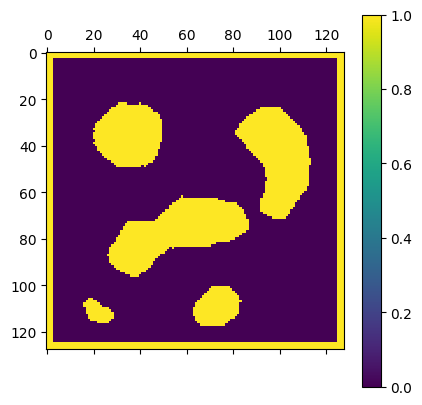

In [25]:
# Load grid map
image = Image.open('map0.png').convert('L')
grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1])/255
# binarize the image
grid_map[grid_map > 0.5] = 1
grid_map[grid_map <= 0.5] = 0
# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1
plt.matshow(grid_map)
plt.colorbar()
plt.show()


In [26]:
def reconstruct_path(node):
    path = []
    while node:
        path.append((node.x, node.y))
        node = node.parent
    return path[::-1]

def find_neighbours(position, map, neighbours_num=4):
    # Extract dimensions of the map
    height, width = map.shape
    y, x = position  # Unpack the position
    neighbours = []  # Initialize an empty list for neighbors

    # Define the relative positions for 4-connectivity and 8-connectivity
    directions_4 = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    directions_8 = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    # Choose directions based on the connectivity required
    directions = directions_4 if neighbours_num == 4 else directions_8

    # Loop through each direction and check if it's valid
    for dy, dx in directions:
        ny, nx = y + dy, x + dx  # Calculate the neighbor's position
        # Check if the neighbor is within bounds and is 0
        if 0 <= ny < height and 0 <= nx < width and map[ny, nx] == 0:
            neighbours.append((ny, nx))  # Add valid neighbor

    return neighbours


In [27]:
def reconstruct_path(node):
    path = []
    while node:
        path.append((node.x, node.y))
        node = node.parent
    return path[::-1]

def find_neighbours(position, map, neighbours_num=4):
    # Extract dimensions of the map
    height, width = map.shape
    y, x = position  # Unpack the position
    neighbours = []  # Initialize an empty list for neighbors

    # Define the relative positions for 4-connectivity and 8-connectivity
    directions_4 = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    directions_8 = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    # Choose directions based on the connectivity required
    directions = directions_4 if neighbours_num == 4 else directions_8

    # Loop through each direction and check if it's valid
    for dy, dx in directions:
        ny, nx = y + dy, x + dx  # Calculate the neighbor's position
        # Check if the neighbor is within bounds and is 0
        if 0 <= ny < height and 0 <= nx < width and map[ny, nx] == 0:
            neighbours.append((ny, nx))  # Add valid neighbor

    return neighbours


In [ ]:

import cv2
import numpy as np
import heapq
import sys
from PIL import Image
from matplotlib import pyplot as plt

class Node:
    def __init__(self, x, y, parent=None):
        self.x = x
        self.y = y
        self.g = 0  # Cost from start node to current node
        self.h = 0  # Heuristic value
        self.f = 0  # Total cost (g + h)
        self.parent = parent

    def calculate_h(self, goal):
        self.h = np.sqrt((self.x - goal.x)**2 + (self.y - goal.y)**2)
        self.f = self.g + self.h

    def __lt__(self, other):
        return self.f < other.f

    def __repr__(self):
        return f"Node({self.x}, {self.y})"
    

 

def a_star_desc(grid, start, goal,num_neigh):
    open_set = []
    heapq.heappush(open_set, start)
    came_from = {}

    start.g = 0
    start.calculate_h(goal)

    closed_set = set()
    
    while open_set:
        current = heapq.heappop(open_set)
        if (current.x, current.y) in closed_set:
            continue

        if current.x == goal.x and current.y == goal.y:
            path = reconstruct_path(current)
            cost = current.g
            return path, cost

        closed_set.add((current.x, current.y))

        for i,neighbor in enumerate(find_neighbours([current.x,current.y], grid, neighbours_num=num_neigh)):#get_neighbors(current, grid)
            neighbor = Node(neighbor[0],neighbor[1],i)
            neighbor.g = np.inf
            neighbor.f = np.inf
            neighbor.parent = current
            if (neighbor, neighbor.y) in closed_set:
                continue

            tentative_g = current.g + np.sqrt((neighbor.x - current.x)**2 + (neighbor.y - current.y)**2)

            if tentative_g < neighbor.g or neighbor not in [n[2] for n in open_set]:
                neighbor.g = tentative_g
                neighbor.calculate_h(goal)
                neighbor.parent = current
                heapq.heappush(open_set, neighbor)

    return None, float('inf')


 

if __name__ == "__main__":
    # if len(sys.argv) != 6:
    #     print("Usage: python a_star_YOUR_NAME.py <path_to_grid_map_image> <start_x> <start_y> <goal_x> <goal_y>")
    #     sys.exit(1)

    # image_path = sys.argv[1]
    # start_x, start_y = int(sys.argv[2]), int(sys.argv[3])
    # goal_x, goal_y = int(sys.argv[4]), int(sys.argv[5])

    # Load the grid map


    image = Image.open('map0.png').convert('L')
    grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1])/255
    # binarize the image
    grid_map[grid_map > 0.5] = 1
    grid_map[grid_map <= 0.5] = 0
    # Invert colors to make 0 -> free and 1 -> occupied
    grid_map = (grid_map * -1) + 1
    # plt.matshow(grid_map)
    # plt.colorbar()
    # plt.show()


    # image = Image.open('map0.png').convert('L')
    # grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1])/255
    # # grid_map = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # _, binary_map = cv2.threshold(grid_map, 127, 255, cv2.THRESH_BINARY)
    # grid = (binary_map == 0).astype(np.uint8)  # Occupied cells are 1, free cells are 0

    start =[10, 10]
    goal = [90,70]

    start_node = Node(start[0], start[1])
    goal_node = Node(goal[0], goal[1])

    path, cost = a_star_desc(grid_map, start_node, goal_node,num_neigh = 4)
    print(cost)
    x_values = list(zip(*path))[0]
    y_values = list(zip(*path))[1] 
    plt.matshow(grid_map)
    plt.colorbar()
    plt.scatter( y_values,x_values, s=2, marker = "*", c="b")
    plt.scatter(goal[1], goal[0], c="r",  marker=(5, 1))
    plt.show()

SyntaxError: unmatched ')' (2980199486.py, line 99)